In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

from torchtext.data import Field
from torchtext.vocab import GloVe
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from utils import preprocessing

sns.set_style('darkgrid')

In [2]:
# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# BERT

## Datos

In [4]:
train_df = pd.read_csv('../../Data/EXIST2021_training.tsv', sep='\t')

# Un simple pre-procesamiento
train_df['text'] = train_df['text'].apply(lambda text: preprocessing.preprocess(text))

# Codificamos las etiquetas
label_encoder = LabelEncoder()
label_encoder.fit(train_df['task1'])

train_df['label'] = label_encoder.transform(train_df['task1'])

train_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,1,twitter,en,"she calls herself "" anti-feminazi "" how about ...",sexist,ideological-inequality,1
1,EXIST2021,2,twitter,en,"now , back to these women , the brave and the ...",non-sexist,non-sexist,0
2,EXIST2021,3,twitter,en,"wow , your skirt is very short . what is it's ...",sexist,objectification,1
3,EXIST2021,4,twitter,en,incredible ! beautiful ! but i laughed so much...,non-sexist,non-sexist,0
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [5]:
test_df = pd.read_csv('../../Data/EXIST2021_test.tsv', sep='\t')

# Un simple pre-procesamiento
test_df['text'] = test_df['text'].apply(lambda text: preprocessing.preprocess(text))

test_df['label'] = label_encoder.transform(test_df['task1'])

test_df.head()

,test_case,id,source,language,text,task1,task2,label
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,EXIST2021,6979,twitter,en,"he sounds like as ass , and very condescending .",non-sexist,non-sexist,0
2,EXIST2021,6980,twitter,en,"lol ! "" this behavior of not letting men tell ...",sexist,ideological-inequality,1
3,EXIST2021,6981,twitter,en,rights ? i mean yeah most women especially the...,sexist,ideological-inequality,1
4,EXIST2021,6982,twitter,en,the jack manifold appreciation i ’ m seeing is...,non-sexist,non-sexist,0


### Dataloaders

En [Huggingface models](https://huggingface.co/models) están los modelos pre-entrenados disponibles. Usaré [bert-base-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased) que está pre-entrenado en 102 idiomas con un corpus de Wikipedia.

In [6]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# bert = BertModel.from_pretrained('bert-base-multilingual-uncased')

# tokenizer(['hello my name is dave']), tokenizer(['hola mi nombre es david'])

In [7]:
class DataSet:    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)
    
class DataSetText:
    
    def __init__(self, file):
        self.y = torch.tensor(file['label'].to_numpy(), dtype=torch.long)
        self.texts = file['text'].tolist()
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
        
    def __getitem__(self, i):
        inputs1 = self.tokenizer(self.texts[i], max_length=128, padding='max_length', truncation=True, return_tensors='pt')
        return torch.squeeze(inputs1['input_ids']), torch.squeeze(inputs1['attention_mask']), torch.squeeze(self.y[i])
        
    def __len__(self):
        return len(self.y)

In [8]:
ds_text_train = DataSetText(train_df)
ds_text_test = DataSetText(test_df)

print(f'Train: {len(ds_text_train)}')
print(f'Test: {len(ds_text_test)}')

Train: 6977
Test: 4368


In [9]:
# Si hago el batch más grande puede que no quepa en la GPU
BATCH_SIZE = 8

train_dl = DataLoader(
    ds_text_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True)

test_dl = DataLoader(
    ds_text_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

## Modelo

In [10]:
class SexismClassifier(nn.Module):
    def __init__(self):
        super(SexismClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        
        self.clf = nn.Sequential(nn.Linear(768, 2), 
                                 nn.Softmax(dim=1))
        
    def forward(self, ids, masks):
        # [batch_size, max_length] -> [batch_size, max_length, 768]
        bert_output = self.bert(input_ids=ids, attention_mask=masks, return_dict=True).last_hidden_state
        
        # [batch_size, max_length, 768] -> [batch_size, 768]
        cls_output = bert_output[:,0,:]
        
        # [batch_size, 768] -> [batch_size, 2]
        y = self.clf(cls_output)

        return y 

In [11]:
def infer(model, loader_test):
    model.eval()
    
    Y = []
    Y_hat = []

    for ids, masks, y_true in loader_test:
        ids = ids.to(device)
        masks = masks.to(device)
        y_true = y_true.to(device)

        y_hat = model(ids, masks)

        loss = F.cross_entropy(y_hat, y_true)

        y_pred = torch.argmax(y_hat, 1)

        Y.extend(y_true.cpu().numpy().tolist() )
        Y_hat.extend(y_pred.cpu().numpy().tolist())
        
    return Y, Y_hat

def test(model, loader_test):
    model.eval()
    
    accs = []
    
    for ids, masks, y_true in loader_test:
        ids = ids.to(device)
        masks = masks.to(device)
        y_true = y_true.to(device)
        
        y_hat = model(ids, masks)
        
        y_pred = torch.argmax(y_hat, 1)
        
        acc = (y_true == y_pred).type(torch.float32).mean()
        
        accs.append(acc.item())
        
    return np.mean(accs)
        

def train(model, loader, loader_test, epocas, lr=1e-5):
    opt = optim.Adam(model.parameters(), lr=lr)
    
    accs_train, accs_test = [], []
    
    for epoca in range(epocas):
        model.train()
        
        accs = []
        for ids, masks, y_true in tqdm(loader):
            opt.zero_grad()

            ids = ids.to(device)
            masks = masks.to(device)
            y_true = y_true.to(device)
            
            y_hat = model(ids, masks)
            
            loss = F.cross_entropy(y_hat, y_true)
            
            y_pred = torch.argmax(y_hat, 1)
            
            acc = (y_true == y_pred).type(torch.float32).mean()
            accs.append(acc.item())
            
            loss.backward()
            opt.step()
        
        acc_train = np.mean(accs)
        accs_train.append(acc_train)
        
        acc_test = test(model, loader_test)
        accs_test.append(acc_test)
        
        print(f'Época {epoca}: train acc:{acc_train} test acc:{acc_test}')
        
    return accs_train, accs_test
            

In [12]:
model = SexismClassifier().to(device)

In [15]:
# berttokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# review = 'die bitch, you are the worst'
# berttokenizer_dict = berttokenizer(review, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
# input_ids = berttokenizer_dict['input_ids']
# attention_mask = berttokenizer_dict['attention_mask']

# model(input_ids, attention_mask)

In [16]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               81,315,072
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Sequential: 1-2                        --
|    └─Linear: 2-4                       1,538
|    └─Softmax: 2-5                      --
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0

In [17]:
%time accs_train, accs_test = train(model, train_dl, test_dl, epocas=5)

  0%|          | 0/872 [00:00<?, ?it/s]

Época 0: train acc:0.6786123853211009 test acc:0.7227564102564102


  0%|          | 0/872 [00:00<?, ?it/s]

Época 1: train acc:0.7834002293577982 test acc:0.7564102564102564


  0%|          | 0/872 [00:00<?, ?it/s]

Época 2: train acc:0.8380160550458715 test acc:0.7481684981684982


  0%|          | 0/872 [00:00<?, ?it/s]

Época 3: train acc:0.8631020642201835 test acc:0.7486263736263736


100%|██████████| 872/872 [02:08<00:00,  6.76it/s]


Época 4: train acc:0.8828841743119266 test acc:0.7227564102564102
CPU times: user 12min 3s, sys: 26.5 s, total: 12min 30s
Wall time: 12min 32s


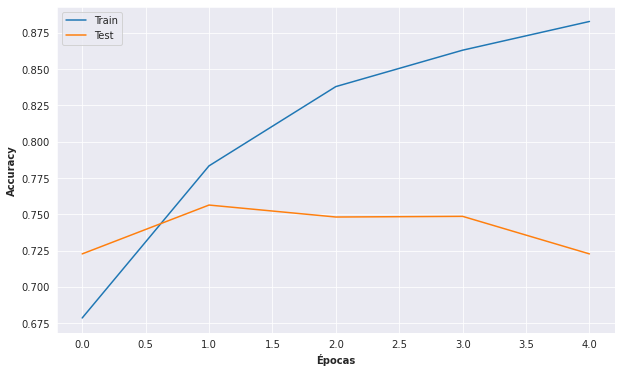

In [18]:
plt.figure(figsize=(10,6))
plt.plot(accs_train, label='Train')
plt.plot(accs_test, label='Test')

plt.xlabel('Épocas', weight='bold')
plt.ylabel('Accuracy', weight='bold')
plt.legend()

plt.show()

- Quizás agregar una capa de `Dropout` para que el accuracy no caiga en test.
- 